In [1]:
import arviz as az
import preliz as pz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit as logistic

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-doc')

# 1. 
Escribir el teorema de Bayes para un modelo jerárquico. 

El teorema de Bayes para un modelo no jerárquico se escribe:
$$
p(\theta \mid Y) = \frac{p(Y \mid \theta) p(\theta)}{p(Y)}
$$

Para llegar a la expresión para un modelo jerárquico tenemos que considerar un _hiperparametro_ $\alpha$ y un _hiperprior_ $p(\alpha)$ que representa nuestro conocimiento previo sobre $\alpha$. Entonces el _prior_ de $\theta$ es condicionado por $\alpha$.

$$
p(\theta) \rightarrow p(\theta \mid \alpha)p(\alpha)
$$
Reescribiendo..
$$
p(\theta, \alpha \mid Y) = \frac{p(Y \mid \theta, \alpha) p(\theta \mid \alpha) p(\alpha)}{p(Y)}
$$

Se simplifica la _likelihood_, ya que los datos no dependen directamente de $\alpha$
$$
p(\theta, \alpha \mid Y) = \frac{p(Y \mid \theta) p(\theta \mid \alpha) p(\alpha)}{p(Y)}
$$

# 2.
   
Describí un ejemplo donde un modelo jerárquico sea más adecuado que un modelo no-jerárquico. Explicá cómo se estructuraría el modelo, incluyendo los niveles de la jerarquía y las dependencias entre los parámetros.

Los modelos jerárquicos son comunmente aplicados en problemas donde se necesita un modelo que interprete que los datos pertenecen a distintos grupos, y que estos se comportan de manera similar.

Supongamos que tenemos los datos de una encuesta en el partido de Tres de Febrero y queremos estimar la preferencia de distintas clases socio-economicas sobre dos partidos politicos (A y B).

Consideramos $\theta_c$ a la probabilidad de la cada clase de votar al partido A y ese parametro se puede modelar como $\theta_c \sim Beta(\alpha, \beta)$.

Como todas las personas de la encuesta son de Tres de Febrero considderamos que los grupos están conectados, por lo tanto podemos asignarle una distribución previa a los parametros $\alpha$ y $\beta$, por ejemplo $\alpha \sim Gamma(11, 2)$ y $\beta \sim Gamma(6, 2)$

La likelihood sería una Bernoulli.

# 3.
Tenés datos de ventas mensuales de diferentes sucursales de una cadena de supermercados. El objetivo es construir un modelo jerárquico para predecir las ventas futuras y entender la variabilidad entre sucursales. Realizá un esquema de como podría ser un modelo de ese tipo.

Suponiendo que tengo un DataFrame de size (n_sucursales, n_meses) y que sucursal es el indice que identifica a cada sucursla. Podría definir al modelo en Python así:  
```python
coords = {"sucursal": range(n_sucursales)}

with pm.Model(coords=coords) as modelo_ventas:
    # Hiperpriors
    μ = pm.Normal('μ', 5000, 500)
    σ = pm.Normal('σ', 500, 25)

    # Prior para la media de cada sucursal
    μ_s = pm.Normal('μ_s', μ, σ, dims="sucursal")
    
    # Prior para la desviación estándar de cada sucursal
    σ_s = pm.HalfNormal('σ_s', 50, dims="sucursal")

    # Likelihood: las ventas mensuales observadas en cada sucursal
    ventas_observadas = pm.Normal('ventas_observadas', mu=μ_s, sigma=σ_s, 
                                  observed=ventas, dims="sucursal")
```
Donde $\mu \sim Normal(5000, 500)$ y $\sigma \sim Normal(500, 25)$ representan nuestro conocimiento previo de la media y la desviacion estandar globales de las ventas mensuales.  
Los priors $\mu_s \sim Normal(\mu, \sigma)$ y $\sigma_s \sim HalfNormal(50)$ nos sirven para entender la variabilidad de entre sucursales.

# 4.
Supongamos que nos piden analizar datos sobre la calidad del agua en una ciudad. Los datos correponden a mediciones de plomo en agua tomadas en varios puntos de la ciudad. Los datos están agrupados por barrios y las muestras con concentraciones de plomo por encima de las recomendaciones de la Organización Mundial de la Salud se marcan con 0 y las muestras con valores por debajo de las recomendaciones se marcan con 1. Este es un escenario muy simple, en un ejemplo más realista, posiblemente tendríamos una medición continua de la concentración de plomo y probablemente muchos más grupos. 

Para este ejercicio, vamos a utilizar datos sintéticos. Vamos a imaginar que hemos recolectado muestras de agua de tres barrios y hemos medido el contenido de plomo del agua; 

```python
N = [30, 30, 30]
G = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N)), N)

data = []
for i in range(0, len(N)):
    data.extend(np.repeat([1, 0], [G[i], N[i]-G[i]]))
```


## a)
Usando notación estadística escribí un modelo jerárquico para este problema. Tip: Utiliza como prior una $\text{Beta}(\mu, \nu)$


Para modelar la _likelihood_ debería usar una distribución $Bernoulli$ ya que los datos tienen la forma $0$ ó $1$.  
El prior para la probabilidad de cada barrio la modelo con $Beta(\mu, \nu)$, como fue sugerido.  
Para encontrar los _hiperpriors_ uso `Preliz.maxent`.  

_Hiperprior_ para $\mu$:

(<Axes: >,
  message: Optimization terminated successfully
  success: True
   status: 0
      fun: 1.140244097821494
        x: [ 2.036e+01  2.036e+01]
      nit: 5
      jac: [ 1.196e-02  1.196e-02]
     nfev: 15
     njev: 5)

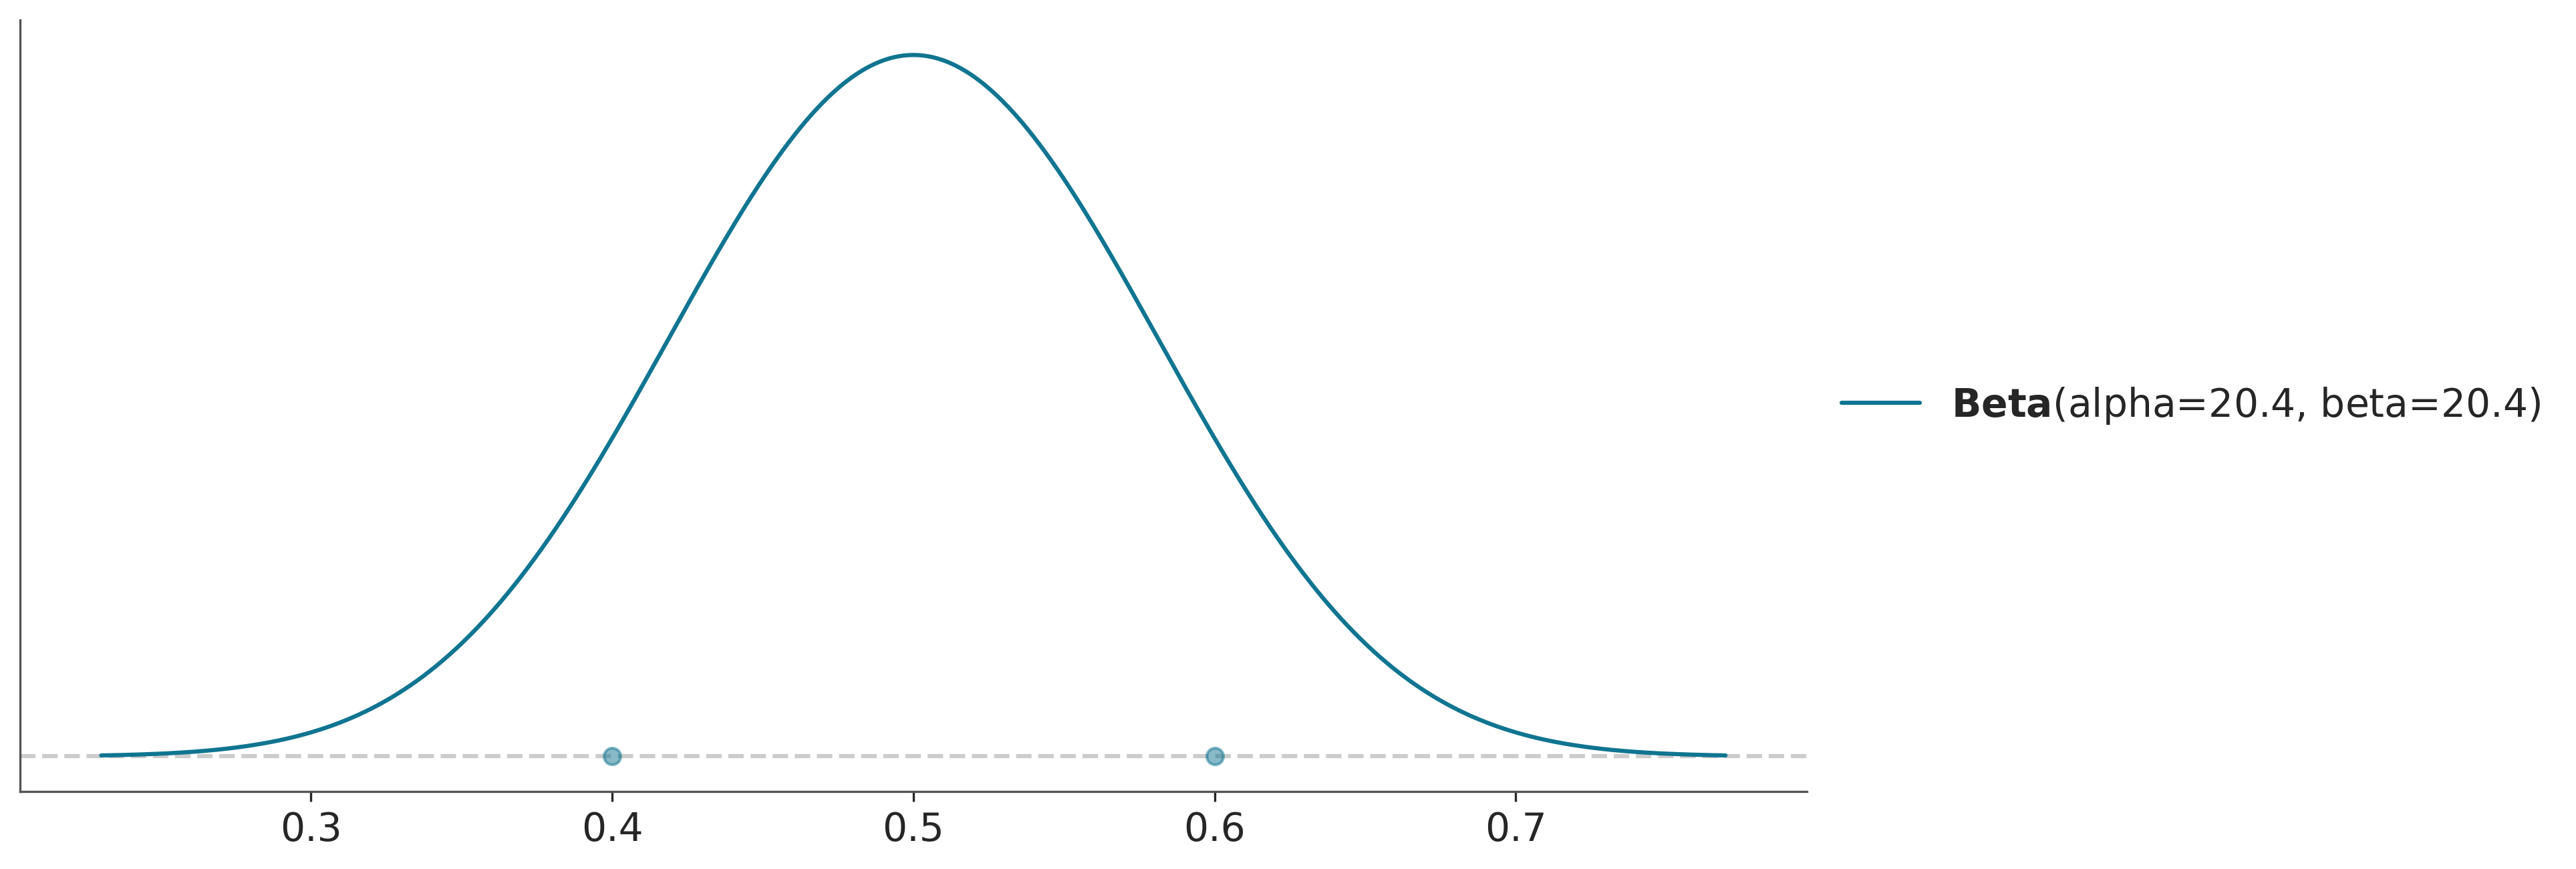

In [40]:
pz.maxent(pz.Beta(), lower=0.4, upper=0.6, mass=0.8)

_Hiperprior_ para $\nu$

(<Axes: >,
  message: Optimization terminated successfully
  success: True
   status: 0
      fun: -2.1323073991837047
        x: [ 9.000e+00  2.041e+00]
      nit: 3
      jac: [ 0.000e+00 -4.900e-01]
     nfev: 10
     njev: 3)

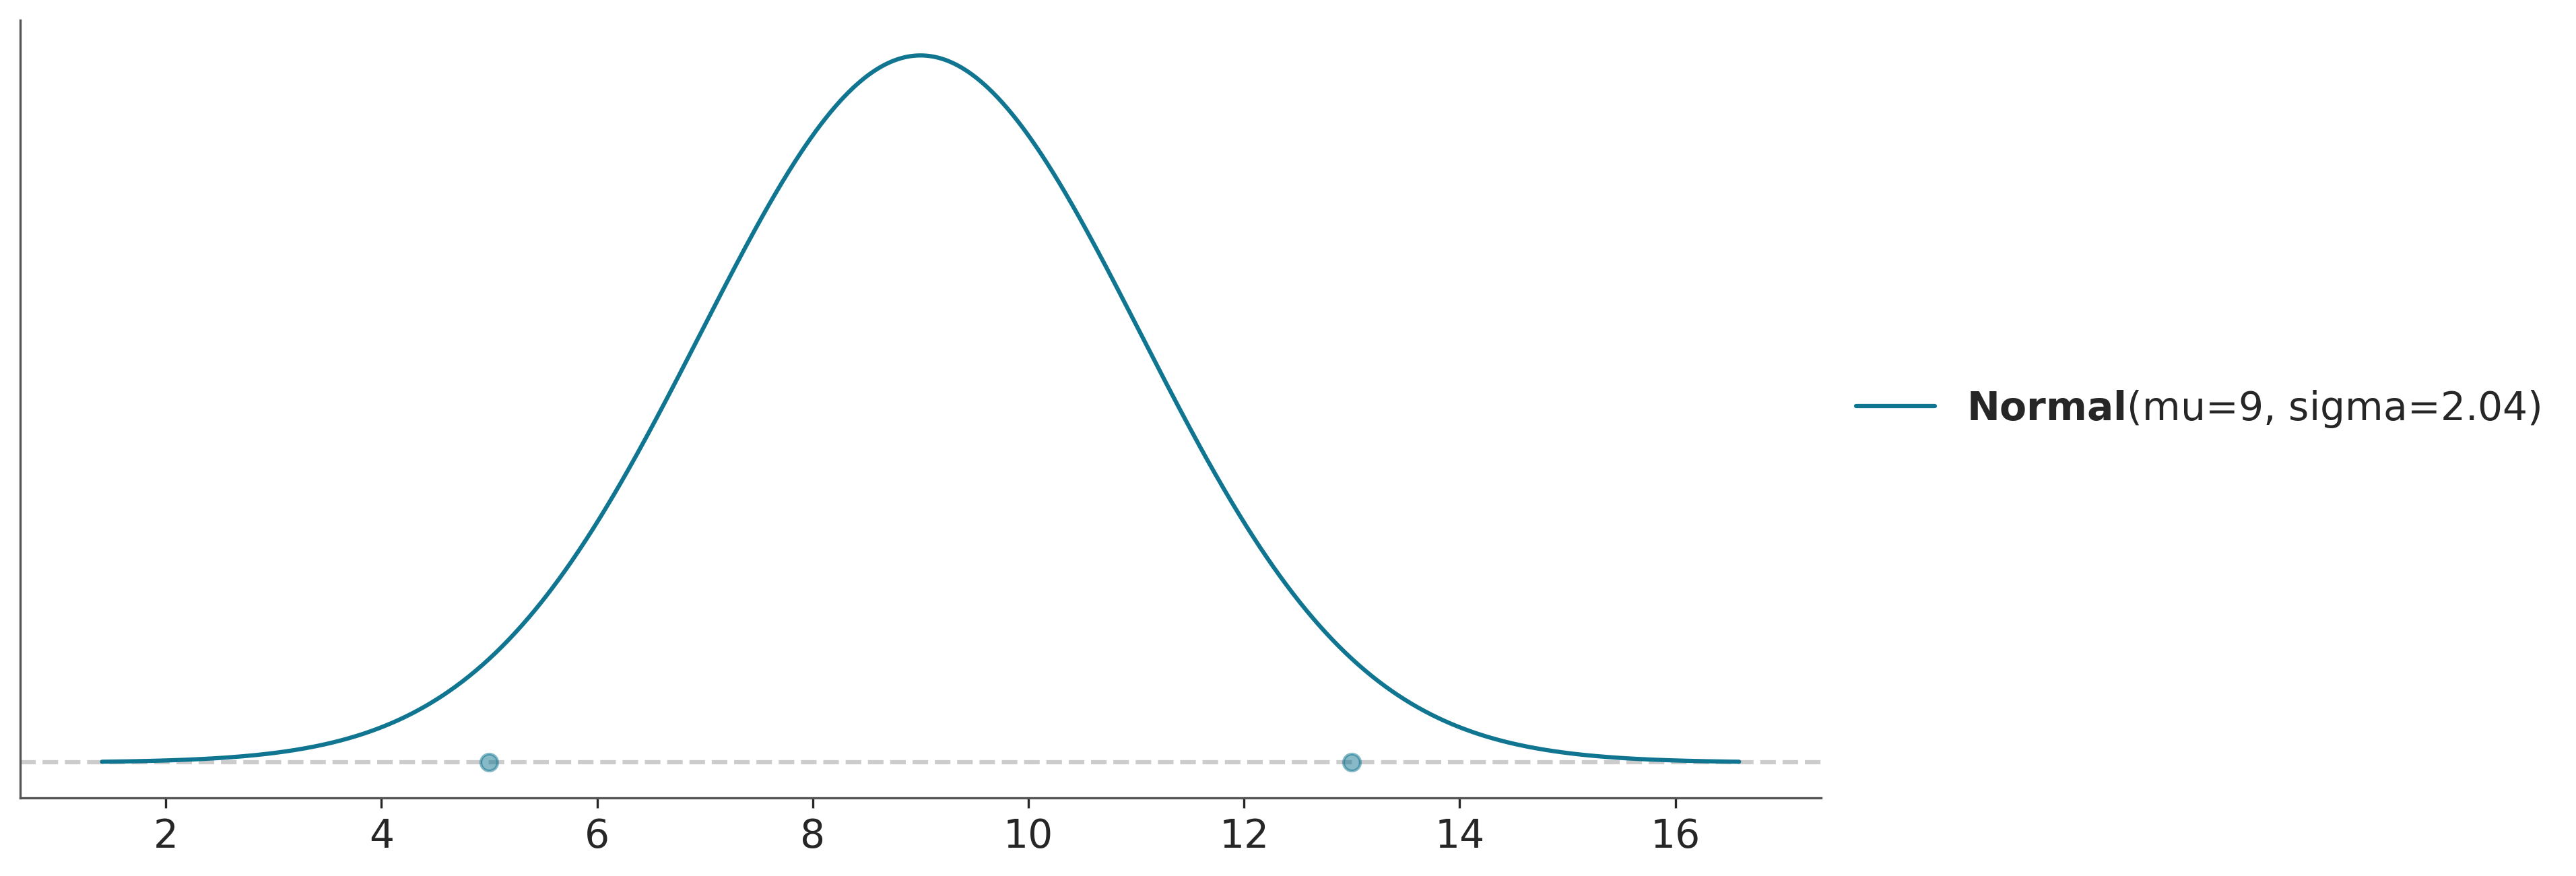

In [42]:
pz.maxent(pz.Normal(), lower=5, upper=13, mass=0.95)

Entoces el modelo queda:

$$
Y_i \sim Bernoulli(\theta_i)  
$$
$$ 
\theta_i \sim Beta(\mu, \nu)
$$
$$  
\mu \sim Beta(\alpha_{\mu} = 20.4, \beta_{\mu} = 20.4)  
$$
$$
\nu \sim Normal(\mu_{\nu} = 9, \sigma_{\nu} = 2.04)
$$

## b)
Usando PyMC implementá el modelo del apartado anterior


In [2]:
N = [30, 30, 30]
G = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N)), N)

data = []
for i in range(0, len(N)):
    data.extend(np.repeat([1, 0], [G[i], N[i]-G[i]]))
    
coords = {
    "group": np.arange(len(N))
}

with pm.Model(coords=coords) as modelo_plomo:
    # hiperpriors
    mu = pm.Beta("mu", alpha= 20.4, beta= 20.4)
    nu = pm.Normal("nu", mu= 9, sigma= 2.04)

    # priors
    theta = pm.Beta("theta", mu=mu, nu=nu, dims="group")

    # likelihood
    y = pm.Bernoulli("y", p=theta[group_idx], dims="group", observed=data)

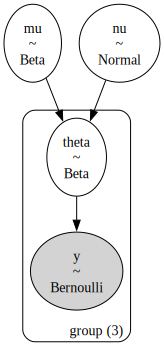

In [3]:
modelo_plomo.to_graphviz()

## c)
Ejecutá el modelo de PyMC 3 veces, resumí los resultados y explicá las diferencias.



### i)   Una ejecución configurando todos los elementos de G a 18


In [9]:
N = [30, 30, 30]
G = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N)), N)

data = []
for i in range(0, len(N)):
    data.extend(np.repeat([1, 0], [G[i], N[i]-G[i]]))
    
coords = {"group": np.arange(len(N))}

with pm.Model(coords=coords) as modelo_plomo:
    # hiperpriors
    mu = pm.Beta("mu", alpha= 20.4, beta= 20.4)
    nu = pm.Normal("nu", mu= 9, sigma= 2.04)

    # priors
    theta = pm.Beta("theta", mu=mu, nu=nu, dims="group")

    # likelihood
    y = pm.Bernoulli("y", p=theta[group_idx], observed=data)

    idata1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, nu, theta]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 94 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



### ii)  Una ejecución configurando todos los elementos de G a 3


In [10]:
N = [30, 30, 30]
G = [3, 3, 3]

group_idx = np.repeat(np.arange(len(N)), N)

data = []
for i in range(0, len(N)):
    data.extend(np.repeat([1, 0], [G[i], N[i]-G[i]]))
    
coords = {"group": np.arange(len(N))}

with pm.Model(coords=coords) as modelo_plomo:
    # hiperpriors
    mu = pm.Beta("mu", alpha= 20.4, beta= 20.4)
    nu = pm.Normal("nu", mu= 9, sigma= 2.04)

    # priors
    theta = pm.Beta("theta", mu=mu, nu=nu, dims="group")

    # likelihood
    y = pm.Bernoulli("y", p=theta[group_idx], observed=data)

    idata2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, nu, theta]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 158 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


### iii) Una última ejecución configurando un elemento en 18 y los otros dos en 3

In [11]:
N = [30, 30, 30]
G = [18, 3, 3]

group_idx = np.repeat(np.arange(len(N)), N)

data = []
for i in range(0, len(N)):
    data.extend(np.repeat([1, 0], [G[i], N[i]-G[i]]))
    
coords = {"group": np.arange(len(N))}

with pm.Model(coords=coords) as modelo_plomo:
    # hiperpriors
    mu = pm.Beta("mu", alpha= 20.4, beta= 20.4)
    nu = pm.Normal("nu", mu= 9, sigma= 2.04)

    # priors
    theta = pm.Beta("theta", mu=mu, nu=nu, dims="group")

    # likelihood
    y = pm.Bernoulli("y", p=theta[group_idx], observed=data)

    idata3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, nu, theta]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 162 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


C:\Users\nazar\AppData\Local\Temp\ipykernel_12440\18624815.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


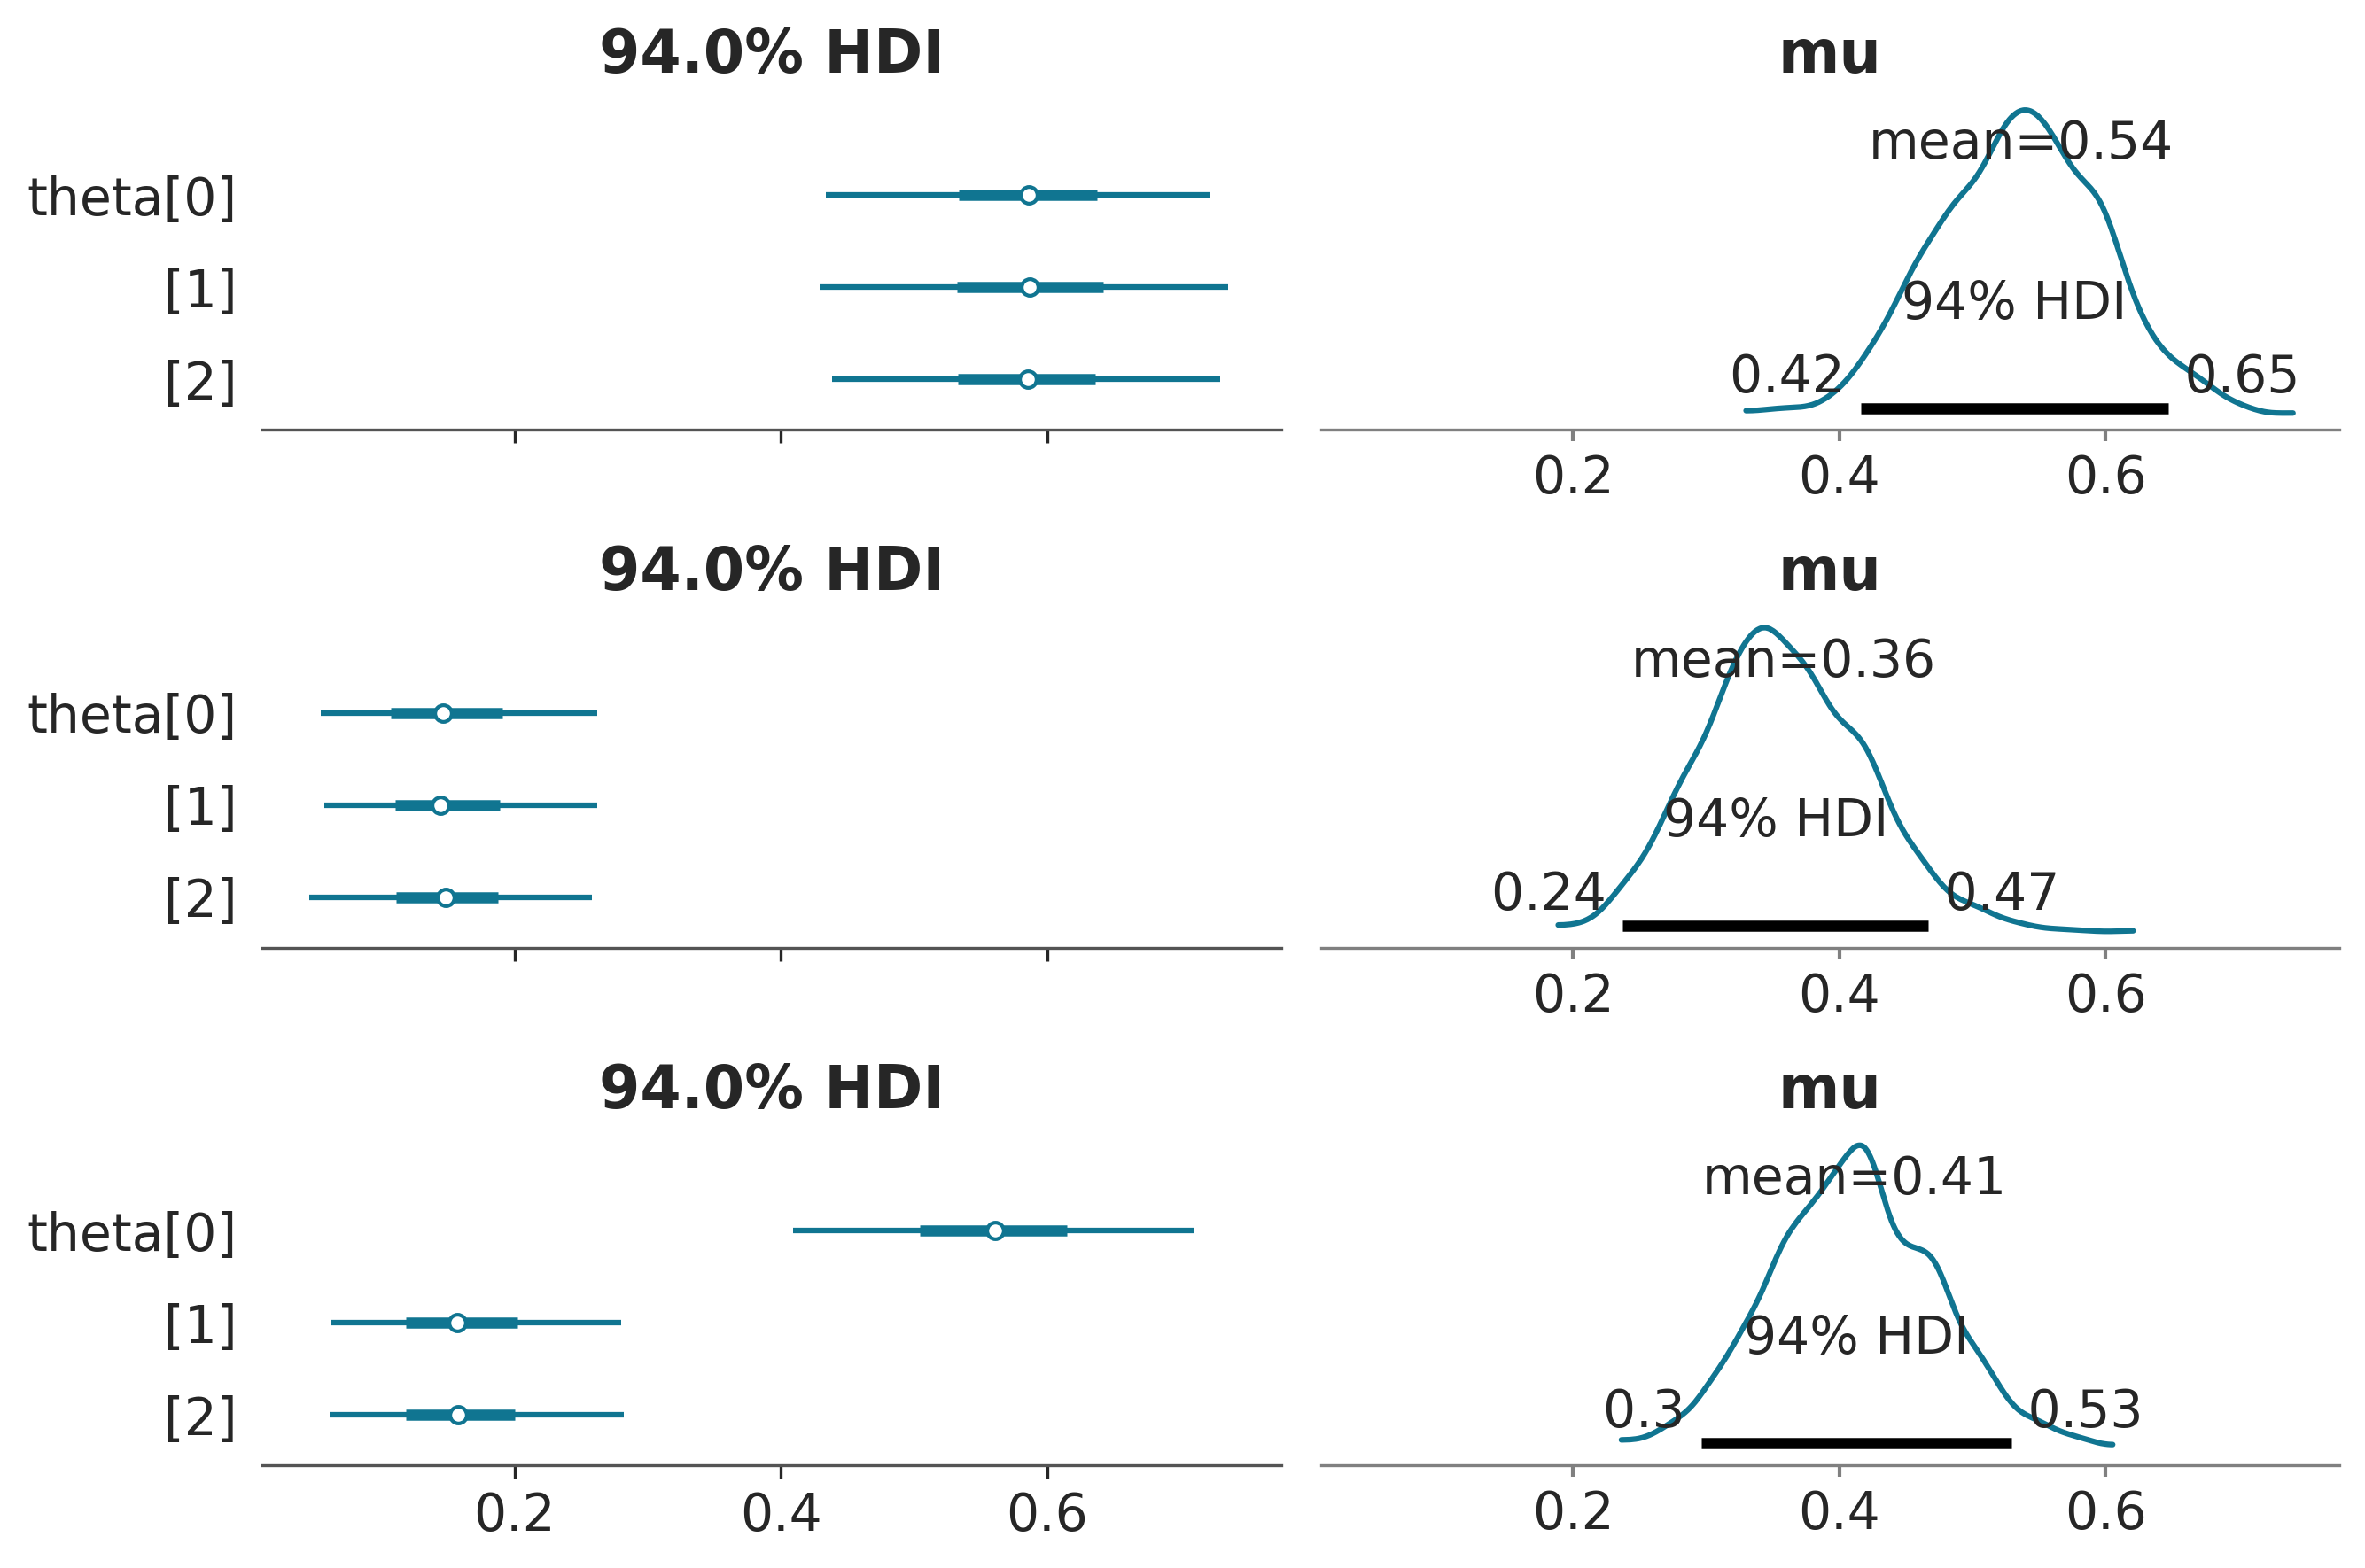

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(9, 6), sharex=True)

idata_list = [idata1, idata2, idata3]

for i, idata in enumerate(idata_list):
    az.plot_forest(idata, var_names=["theta"], combined=True, ax=axes[i, 0])
    az.plot_posterior(idata, var_names="mu", ax=axes[i, 1])

plt.tight_layout()
plt.show()

Como era de esperarse la probabilidad media global se mueve hacia valores más bajos cuando hay grupos con menos observaciones por encima del umbral de la OMS.  
Lo mismo pasa con la probabilidad de cada barrio.  
Esto puede ser porque los _priors_ e _hiperpriors_ no son muy informativos.

# 5.
Creá una versión jerárquica para el ejemplo de las propinas, agrupando parcialmente los días de la semana.

In [36]:
tips = pd.read_csv("../datos/propinas.csv")
categories = np.array(["Jue", "Vie", "Sab", "Dom"])

tip = tips["propina"].values
idx = pd.Categorical(tips["dia"], categories=categories).codes

coords = {"dia": categories}

with pm.Model(coords=coords) as modelo_propinas:
    # hiperpriors (con maxent)
    sigma_μ = pm.Gamma("sigma_μ", alpha=22.8, beta=4.61)
    sigma_σ = pm.Gamma("sigma_σ", alpha=14.1, beta=14.4)
    # priors
    μ = pm.HalfNormal("μ", sigma=sigma_μ, dims="dia")
    σ = pm.HalfNormal("σ", sigma=sigma_σ, dims="dia")

    # likelihood
    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip)

    idata_cg = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_μ, sigma_σ, μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1278 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

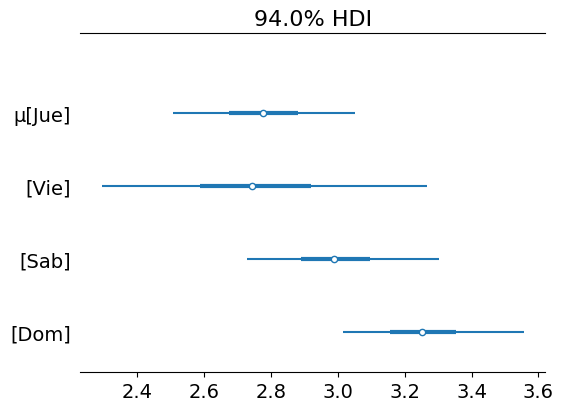

In [38]:
az.plot_forest(idata_cg, var_names=["μ"], combined=True)

Los resultados son practicamente los mismos que los obtenidos en la practica anterior.

# 6. 
Cuando se utilizan distribuciones a priori débilmente informativas, las predicciones medias a posteriori de un modelo normal-normal jerárquico son (aproximadamente) promedios pesado de la siguiente forma $
\frac{\sigma^2_y}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_{\text{global}} + \frac{n_j\sigma^2_\mu}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_j$. Donde $\overline{y}_{\text{global}}$ es la media de todas las observaciones, $\overline{y}_j$ es la media de las observaciones en el grupo $j$, $n_j$ es el número de observaciones en el grupo $j$, $\sigma^2_y$ es la varianza de las observaciones y $\sigma^2_\mu$ es la varianza de las medias de los grupos. Indique en que condiciones las prediccions a nivel individual se contraeran más hacia la predicción global.


Las predicciones se contraeran hacia la media global cuando el segundo término tienda a cero, esto sucede cuando:
+ $\sigma_y^2 \rightarrow \infty$
+ $n_j \rightarrow 0$
+ $\sigma_{\mu}^2 \rightarrow 0$ 

Osea que las predicciones se contraen hacia la media global cuando la varianza de las observaciones es muy grande, cuando la cantidad de observaciones dentro de un grupo es muy pequeña y cuando la varianza entre las medias de los grupos es baja. 

# 7.
(Extra) Aplicá uno de los modelos vistos en este capítulo a datos propios o de tu interés.

Voy a usar los mismos datos que en la practica anterior y ver si cambia algo.

In [3]:
url = "https://github.com/nazarenomm/estadistica_e_inferencia_II/raw/main/datos/insurance.csv"
df = pd.read_csv(url)

df['grupo'] = df.apply(lambda x: (
    'Fumador - BMI >= 30' if x['smoker'] == 'yes' and x['bmi'] >= 30 else
    'No Fumador - BMI < 30' if x['smoker'] == 'no' and x['bmi'] < 30 else
    'Fumador - BMI < 30' if x['smoker'] == 'yes' and x['bmi'] < 30 else
    'No Fumador - BMI >= 30'
), axis=1)

charges = df["charges"].values / 1000
categorias = df["grupo"].unique()
idx = pd.Categorical(df["grupo"], categories=categorias).codes

coords = {"grupo": categorias, "grupo_flat": categorias[idx]}

Voy a cambiar los priors por unos un poco más informativos.

In [10]:
with pm.Model(coords = coords) as modelo_jerarquico:
    # hiperpriors
    alpha_μ = pm.Gamma("alpha_μ", alpha=33, beta=9)
    beta_μ = pm.Gamma("beta_μ", alpha=3, beta=29)
    # priors
    μ = pm.Gamma("μ", alpha=alpha_μ, beta= beta_μ, dims="grupo")
    σ = pm.Uniform("σ", lower= 10, upper=15, dims="grupo")

    y = pm.TruncatedNormal("y", mu=μ[idx], sigma=σ[idx], lower= 0 ,observed=charges)

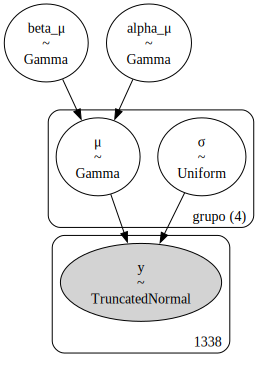

In [11]:
modelo_jerarquico.to_graphviz()

In [12]:
with modelo_jerarquico:
    idata_hc = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_μ, beta_μ, μ, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2860 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [13]:
with modelo_jerarquico:
    idata_hc.extend(pm.sample_posterior_predictive(idata_hc))

Sampling: [y]


Output()

array([<Axes: title={'center': 'μ\nFumador - BMI < 30'}>,
       <Axes: title={'center': 'μ\nNo Fumador - BMI >= 30'}>,
       <Axes: title={'center': 'μ\nNo Fumador - BMI < 30'}>,
       <Axes: title={'center': 'μ\nFumador - BMI >= 30'}>], dtype=object)

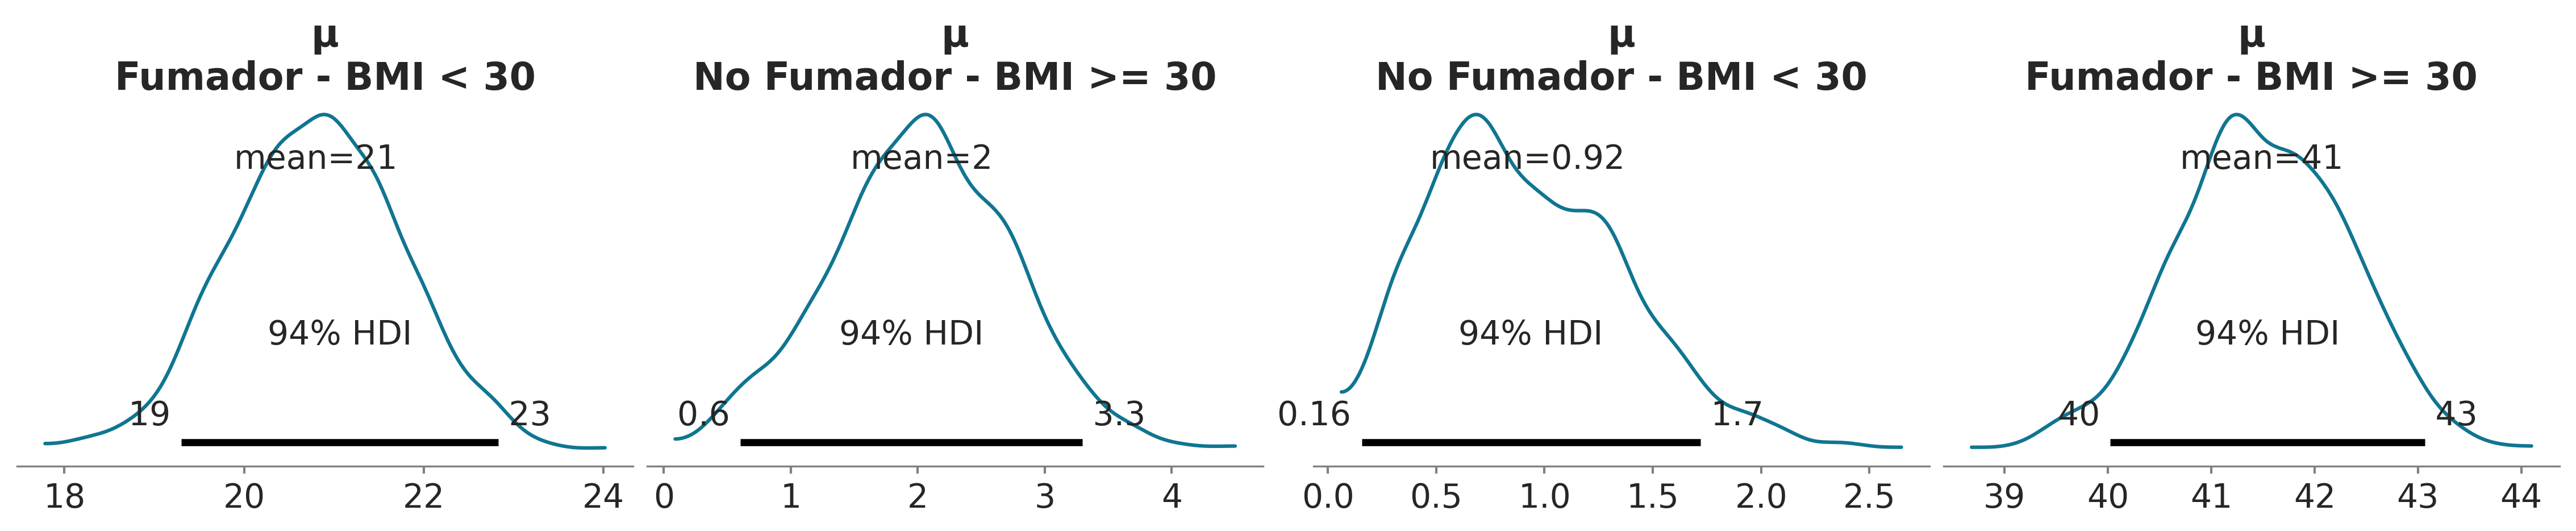

In [25]:
az.plot_posterior(idata_hc, var_names="μ", figsize=(15, 3))

Los resultados son muy parecidos salvo que las medias más bajas subieron un poco, ésto puede ser porque los modelos jerarquicos acercan hacia la media global.  
También puede ser porque usé otro prior para $\mu$.